In [37]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/stanford-car-dataset-images-in-224x224/stanford-car-dataset-by-classes-folder-224/names.csv
/kaggle/input/stanford-car-dataset-images-in-224x224/stanford-car-dataset-by-classes-folder-224/anno_test.csv
/kaggle/input/stanford-car-dataset-images-in-224x224/stanford-car-dataset-by-classes-folder-224/anno_train.csv
/kaggle/input/stanford-car-dataset-images-in-224x224/stanford-car-dataset-by-classes-folder-224/car_data/test/Dodge Ram Pickup 3500 Crew Cab 2010/04772.jpg
/kaggle/input/stanford-car-dataset-images-in-224x224/stanford-car-dataset-by-classes-folder-224/car_data/test/Dodge Ram Pickup 3500 Crew Cab 2010/08033.jpg
/kaggle/input/stanford-car-dataset-images-in-224x224/stanford-car-dataset-by-classes-folder-224/car_data/test/Dodge Ram Pickup 3500 Crew Cab 2010/03004.jpg
/kaggle/input/stanford-car-dataset-images-in-224x224/stanford-car-dataset-by-classes-folder-224/car_data/test/Dodge Ram Pickup 3500 Crew Cab 2010/06551.jpg
/kaggle/input/stanford-car-dataset-images-in-224x

In [38]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

tf.keras.mixed_precision.set_global_policy('mixed_float16')


In [39]:
train_dir = '/kaggle/input/stanford-car-dataset-images-in-224x224/stanford-car-dataset-by-classes-folder-224/car_data/train'
test_dir = '/kaggle/input/stanford-car-dataset-images-in-224x224/stanford-car-dataset-by-classes-folder-224/car_data/test'


In [101]:
batch_size = 32
img_size = (224, 224)
AUTOTUNE = tf.data.AUTOTUNE


In [102]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size,
    validation_split=.2,
    subset="training", 
    seed=123,  
    label_mode='categorical',
    shuffle=True
)

Found 8144 files belonging to 196 classes.
Using 6516 files for training.


In [103]:
val_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size,
    validation_split=.2,
    subset="validation", 
    seed=123,
    label_mode='categorical',
    shuffle=True
)

Found 8144 files belonging to 196 classes.
Using 1628 files for validation.


In [104]:
class_names = train_dataset.class_names
num_classes = len(class_names)
print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")


Number of classes: 196
Class names: ['AM General Hummer SUV 2000', 'Acura Integra Type R 2001', 'Acura RL Sedan 2012', 'Acura TL Sedan 2012', 'Acura TL Type-S 2008', 'Acura TSX Sedan 2012', 'Acura ZDX Hatchback 2012', 'Aston Martin V8 Vantage Convertible 2012', 'Aston Martin V8 Vantage Coupe 2012', 'Aston Martin Virage Convertible 2012', 'Aston Martin Virage Coupe 2012', 'Audi 100 Sedan 1994', 'Audi 100 Wagon 1994', 'Audi A5 Coupe 2012', 'Audi R8 Coupe 2012', 'Audi RS 4 Convertible 2008', 'Audi S4 Sedan 2007', 'Audi S4 Sedan 2012', 'Audi S5 Convertible 2012', 'Audi S5 Coupe 2012', 'Audi S6 Sedan 2011', 'Audi TT Hatchback 2011', 'Audi TT RS Coupe 2012', 'Audi TTS Coupe 2012', 'Audi V8 Sedan 1994', 'BMW 1 Series Convertible 2012', 'BMW 1 Series Coupe 2012', 'BMW 3 Series Sedan 2012', 'BMW 3 Series Wagon 2012', 'BMW 6 Series Convertible 2007', 'BMW ActiveHybrid 5 Sedan 2012', 'BMW M3 Coupe 2012', 'BMW M5 Sedan 2010', 'BMW M6 Convertible 2010', 'BMW X3 SUV 2012', 'BMW X5 SUV 2007', 'BMW X6

In [105]:
normalization_layer = layers.Rescaling(1./255)

In [106]:
# data_augmentation = tf.keras.Sequential([
#     layers.RandomFlip("horizontal", input_shape=img_size + (3,)),  # Random horizontal flip
#     layers.RandomRotation(0.2),  # Random rotation of 20% max
#     layers.RandomZoom(0.2),  # Random zoom of 20% max
#     layers.RandomContrast(0.2),  # Random contrast adjustment
# ])

In [107]:
train_dataset = (train_dataset
                 # .map(lambda x, y: (data_augmentation(x), y), num_parallel_calls=AUTOTUNE)
                 .map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)
                 .cache()
                 .shuffle(1000)
                 .prefetch(buffer_size=AUTOTUNE))

In [108]:
val_dataset = (val_dataset
               .map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)
               .cache()
               .prefetch(buffer_size=AUTOTUNE))

In [109]:
print(f"Train batches: {len(train_dataset)}")
print(f"Validation batches: {len(val_dataset)}")

Train batches: 204
Validation batches: 51


In [110]:
def conv_block(x, filters, kernel_size, stride=1, activation=True):
    
    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    if activation:
        x = layers.ReLU()(x)
    return x

In [111]:
def residual_block(x, filters, stride=1):
    
    shortcut = x
    
    x = conv_block(x, filters, kernel_size=3, stride=stride, activation=True)
   
    x = conv_block(x, filters, kernel_size=3, stride=1, activation=False)
    
    if shortcut.shape[-1] != filters or stride != 1:
        shortcut = conv_block(shortcut, filters, kernel_size=1, stride=stride, activation=False)

    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)
    return x

In [112]:
def build_resnet18(input_shape, num_classes):

    inputs = layers.Input(shape=input_shape)
    
    x = conv_block(inputs, 64, kernel_size=7, stride=2)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)
    
    for filters, blocks, stride in zip([64, 128, 256, 512], [2, 2, 2, 2], [1, 2, 2, 2]):
        for i in range(blocks):
            x = residual_block(x, filters, stride if i == 0 else 1)

    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax', dtype='float32')(x)

    model = models.Model(inputs, outputs)
    return model

In [113]:
resnet18 = build_resnet18(input_shape=(224, 224, 3), num_classes=num_classes)
resnet18.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_60 (Conv2D)  │ (None, 112, 112,  │      9,408 │ input_layer_3[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_60[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_51 (ReLU)     │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 56, 56,    │          0 │ re_lu_51[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_61 (Conv2D)  │ (None, 56, 56,    │     36,864 │ max_pooling2d_3[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_61[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_52 (ReLU)     │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_62 (Conv2D)  │ (None, 56, 56,    │     36,864 │ re_lu_52[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_62[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_24 (Add)        │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_53 (ReLU)     │ (None, 56, 56,    │          0 │ add_24[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_63 (Conv2D)  │ (None, 56, 56,    │     36,864 │ re_lu_53[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_63[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_54 (ReLU)     │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_64 (Conv2D)  │ (None, 56, 56,    │     36,864 │ re_lu_54[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_64[0][0] 

 Total params: 11,286,660 (43.06 MB)

 Trainable params: 11,277,060 (43.02 MB)

 Non-trainable params: 9,600 (37.50 KB)

In [114]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')

In [115]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=1000,
    decay_rate=0.9
)

In [116]:
resnet18.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

In [117]:
import warnings

warnings.filterwarnings('ignore')

In [118]:
history = resnet18.fit(train_dataset,
                       validation_data=val_dataset,
                       callbacks=[ checkpoint],
                       epochs=30,
                      verbose=1)

Epoch 1/30
204/204 ━━━━━━━━━━━━━━━━━━━━ 45s 101ms/step - accuracy: 0.0077 - loss: 5.7303 - val_accuracy: 0.0074 - val_loss: 5.5740
Epoch 2/30
204/204 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.0212 - loss: 5.1474 - val_accuracy: 0.0135 - val_loss: 5.4052
Epoch 3/30
204/204 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.0315 - loss: 4.9206 - val_accuracy: 0.0147 - val_loss: 5.7662
Epoch 4/30
204/204 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.0553 - loss: 4.6962 - val_accuracy: 0.0178 - val_loss: 7.5073
Epoch 5/30
204/204 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.0702 - loss: 4.4556 - val_accuracy: 0.0289 - val_loss: 5.7780
Epoch 6/30
204/204 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.1005 - loss: 4.2015 - val_accuracy: 0.0369 - val_loss: 5.4394
Epoch 7/30
204/204 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.1370 - loss: 3.8966 - val_accuracy: 0.0479 - val_loss: 5.2670
Epoch 8/30
204/204 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - accuracy: 0.1921 - loss: 3.5450 - val

In [119]:
test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

Found 8041 files belonging to 196 classes.


In [120]:
test_dataset = (test_dataset
                .map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)
                .cache()
                .prefetch(buffer_size=AUTOTUNE))

In [121]:
resnet18.load_weights('/kaggle/working/best_model.keras')


In [122]:
test_loss, test_accuracy = resnet18.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

252/252 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.1946 - loss: 4.2100
Test Accuracy: 19.74%


training and validation accuracy plot

In [123]:
def plot_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Loss over Epochs')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy over Epochs')
    plt.show()


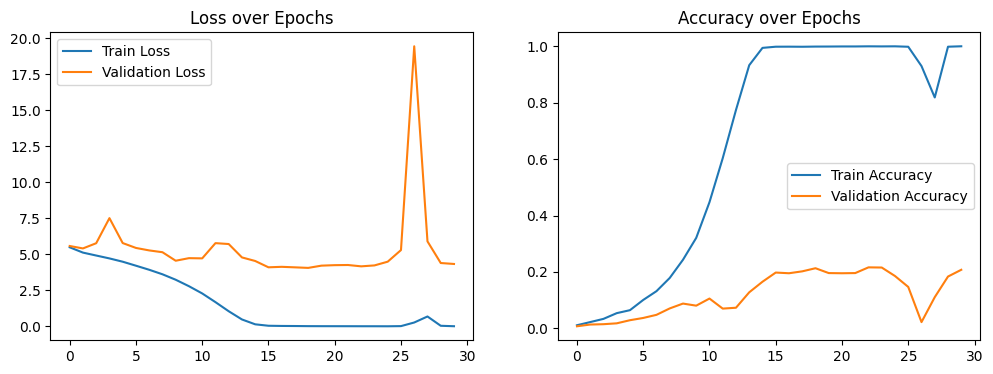

In [124]:
plot_history(history)

In [125]:
import numpy as np
Y_pred = resnet18.predict(test_dataset)
y_pred = np.argmax(Y_pred, axis=1)
y_true = []
for _, labels in test_dataset:
    y_true.extend(labels.numpy()) 

y_true_one_hot = np.array(y_true)


252/252 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step


In [128]:
print(f"y_true shape: {y_true_one_hot.shape}")
print(f"y_pred shape: {y_pred.shape}")
print(y_true_one_hot[:5]) 


y_true shape: (8041, 196)
y_pred shape: (8041,)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [130]:
if len(y_true_one_hot.shape) > 1 and y_true_one_hot.shape[1] > 1:
    y_true = np.argmax(y_true_one_hot, axis=1)


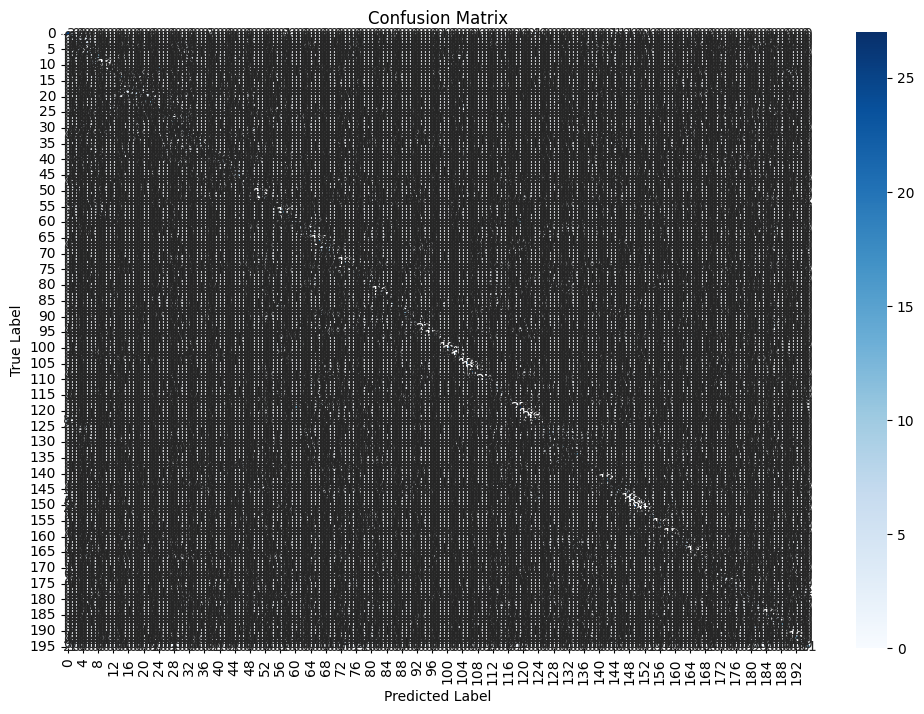

In [131]:
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [132]:
report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:\n", report)


Classification Report:
                                                         precision    recall  f1-score   support

                            AM General Hummer SUV 2000       0.39      0.57      0.46        44
                             Acura Integra Type R 2001       0.13      0.20      0.16        44
                                   Acura RL Sedan 2012       0.19      0.16      0.17        32
                                   Acura TL Sedan 2012       0.31      0.26      0.28        43
                                  Acura TL Type-S 2008       0.18      0.19      0.19        42
                                  Acura TSX Sedan 2012       0.04      0.05      0.05        40
                              Acura ZDX Hatchback 2012       0.14      0.21      0.17        39
              Aston Martin V8 Vantage Convertible 2012       0.05      0.04      0.05        45
                    Aston Martin V8 Vantage Coupe 2012       0.14      0.22      0.17        41
               

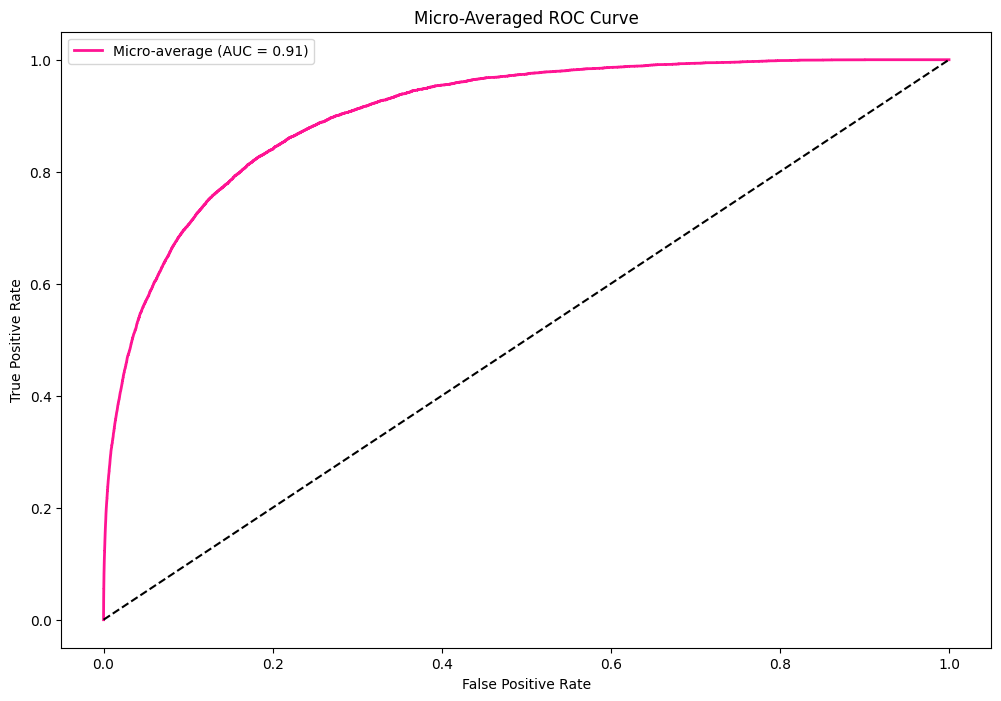

In [133]:
fpr = {}
tpr = {}
roc_auc = {}

fpr["micro"], tpr["micro"], _ = roc_curve(y_true_one_hot.ravel(), Y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


plt.figure(figsize=(12, 8))
plt.plot(fpr["micro"], tpr["micro"], label=f'Micro-average (AUC = {roc_auc["micro"]:.2f})', color='deeppink', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-Averaged ROC Curve')
plt.legend()
plt.show()
